# Movie Sentiment Analysis : A Multinomial Naïve Bayes-Based Approach for Assessing User and Critic Opinions

## *Abstract*

*The growing volume of user-generated content, particularly in the form of movie reviews, presents both challenges and opportunities for researchers and practitioners in the movie industry. Movie sentiment analysis has emerged as a vital tool to automatically process and interpret this vast repository of data, offering valuable insights into viewer preferences and opinions. In this project, we involve a comprehensive study of relevant NLP techniques, including data pre-processing, feature extraction, and model selection. The chosen Multinomial Naïve Bayes algorithm will be trained and optimized on a dataset of user critic reviews, with model performance evaluated based on multiple evaluation metrics.*

## Import Libaries

In [22]:
import numpy as np # library for linear algebra and math utils
import pandas as pd # dataframe library
import matplotlib.pyplot as plt # plotting library
import seaborn as sns # data visualization


# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB # classifier 
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.feature_extraction.text import TfidfVectorizer

# text preprocessing modules
import nltk
from string import punctuation 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

# dependencies
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
):
    nltk.download(dependency)
    
import warnings
warnings.filterwarnings("ignore")

# stopwords
nltk.download('stopwords')

# seeding
np.random.seed(123)

[nltk_data] Downloading package brown to /Users/kheey/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to /Users/kheey/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kheey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kheey/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/kheey/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kheey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the Data

In [2]:
# load data
data = pd.read_csv("data/labeledTrainData.tsv", sep='\t')

Show sample of the dataset.

In [3]:
# show the first five rows of our labeled dataset
data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


Our dataset has 3 columns.

- Id — This is the id of the review
- Sentiment — either positive(1) or negative(0)
- Review — comment about the movie


Check the shape of the dataset.

In [4]:
# check the shape of the data
data.shape

(25000, 3)

The dataset has 25,000 reviews.

We need to check if the dataset has any missing values.

In [5]:
# check missing values in data
data.isnull().sum()

id           0
sentiment    0
review       0
dtype: int64

The output shows that our dataset does not have any missing values.

> How to Evaluate Class Distribution ?

We can use the value_counts() method from the pandas package to evaluate the class distribution from our dataset.

In [6]:
# evaluate news sentiment distribution
data.sentiment.value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [62]:
def plot_sentiment_distribution(data, column_name="sentiment") -> None:
    """
    Plots a bar chart representing the sentiment distribution of movie reviews.

    Parameters:
    data (pd.DataFrame): A DataFrame containing the movie reviews data.
    column_name (str, optional): The name of the column containing sentiment
                                 values. Defaults to 'sentiment'.

    Returns:
    None
    """
    
    # set the style for the seaborn plot
    sns.set(style="darkgrid", font_scale=1.1)
    sns.set_palette("hls")

    # calculate sentiment counts
    sentiment_counts = data[column_name].value_counts()

    # create a bar plot for sentiment distribution
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

    # customize gridlines
    ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

    # set labels and title
    ax.set_title('Sentiment Distribution', fontsize=16)
    ax.set_xticklabels(['Negative (0)', 'Positive (1)'], fontsize=12)

    # display values on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.show()
    
    # reset the default style for seaborn
    sns.reset_defaults()


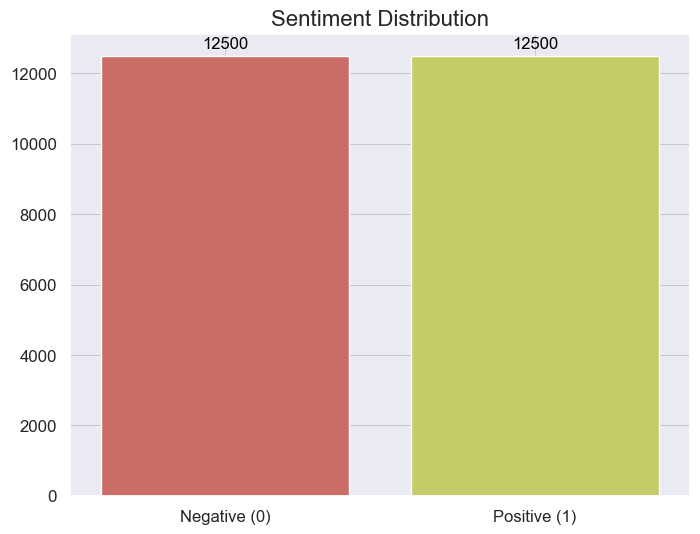

In [63]:
# Plot the sentiment distribution
plot_sentiment_distribution(data)

In this dataset, we have an equal number of positive and negative reviews.

## Preprocessing the Data

For any machine learning project, once you've gathered the data, the first step is to process it to make useful inputs to your model.
- Remove stopwords: You will first want to remove noise from your data -- that is, remove words that don't tell you much about the content. These include all common words like 'I, you, are, is, etc...' that would not give us enough information on the sentiment.
- Remove stock market tickers, retweet symbols, hyperlinks, and hashtags because they can not tell you a lot of information on the sentiment.
- Remove all the punctuation from a tweet. The reason for doing this is because we want to treat words with or without the punctuation as the same word, instead of treating "happy", "happy?", "happy!", "happy," and "happy." as different words.
- Finally you want to use stemming to only keep track of one variation of each word. In other words, we'll treat "motivation", "motivated", and "motivate" similarly by grouping them within the same stem of "motiv-".

The `process_review` function will handle all necessary steps to clean our dataset.

In [9]:
stop_words = stopwords.words("english")


def process_review(text, remove_stop_words=True, lemmatize_words=True, stemming_words=True) -> str:
    """
    Clean and preprocess text data by removing unwanted characters, stop words, and lemmatizing words.

    This function takes a raw text input and processes it by removing non-alphanumeric characters,
    punctuation, numbers, and optionally, stop words, lemmatizing and stemming. The output is a cleaned
    and preprocessed version of the input text.

    Parameters:
    text (str): The raw text input to be processed.
    remove_stop_words (bool, optional): If True, removes stop words from the input text. Defaults to True.
    lemmatize_words (bool, optional): If True, lemmatizes words in the input text. Defaults to True.
    lemmatize_words (bool, optional): If True, lemmatizes words in the input text. Defaults to True.

    Returns:
    str: The cleaned and preprocessed version of the input text.
    """

    # clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r'https?://[^\s]+', '', text) # remove hyperlinks
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text)  # remove numbers

    # remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])

    # remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)

    # lemmatize words
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
        
    # shorten words to their stems
    if stemming_words:
        text = text.split()
        stemmer = PorterStemmer()
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)

    return (text)


Let's test our function on a sample review.

In [10]:
custom_review = "@Thor Thank you, Taika! Laughed for the first time in a week!:) Great, fun, full hearted, just go watch it and have fun!!! #good #film https://chapagain.com"

# print cleaned tweet
print(process_review(custom_review))

thor thank taika laugh first time week great fun full heart go watch fun good film http chapagain com


Now we can clean our dataset by using the process_review() function.

In [11]:
#clean the review
data["cleaned_review"] = data["review"].apply(process_review)

Then we split data into feature and target variables.

In [12]:
#split features and target from  data 
X = data["cleaned_review"]
y = data.sentiment.values

Our feature for training is the cleaned_review variable and the target is the sentiment variable.

We then split our dataset into train and test data. The test size is 15% of the entire dataset.

In [13]:
# split data into train and validate
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    shuffle=True,
    stratify=y,
)

## Multinomial Naive Bayes algorithm

We will train the Multinomial Naive Bayes algorithm to classify if a review is positive or negative. This is one of the most common algorithms used for text classification.

But before training the model, we need to transform our cleaned reviews into numerical values so that the model can understand the data. In this case, we will use the TfidfVectorizer method from scikit-learn. TfidfVectorizer will help us to convert a collection of text documents to a matrix of TF-IDF features.

To apply this series of steps(pre-processing and training), we will use a Pipeline class from scikit-learn that sequentially applies a list of transforms and a final estimator.

In [14]:
# Create a classifier in pipeline
sentiment_classifier = Pipeline(steps=[
                               ('pre_processing',TfidfVectorizer(lowercase=False)),
                                 ('naive_bayes',MultinomialNB())
                                 ])

Then we train our classifier.

In [15]:
# train the sentiment classifier 
sentiment_classifier.fit(X_train,y_train)

Pipeline(steps=[('pre_processing', TfidfVectorizer(lowercase=False)),
                ('naive_bayes', MultinomialNB())])

## Evaluating the model

We then create a prediction from the validation set.

In [16]:
# test model performance on valid data 
y_preds = sentiment_classifier.predict(X_valid)

The model’s performance will be evaluated by using accuracy_score, classification_report and confusion matrix.

In [23]:
accuracy = accuracy_score(y_valid, y_preds)
cm = confusion_matrix(y_valid, y_preds)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8627


In [25]:
report = classification_report(y_valid, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1875
           1       0.87      0.85      0.86      1875

    accuracy                           0.86      3750
   macro avg       0.86      0.86      0.86      3750
weighted avg       0.86      0.86      0.86      3750



In [66]:
def display_confusion_matrix(y_true, y_pred, labels=None) -> None:
    
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    cmap = plt.cm.Blues
    disp = disp.plot(cmap=cmap, xticks_rotation='vertical', values_format='d')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Sentiment Classification Model')
    plt.tight_layout()
    plt.show()

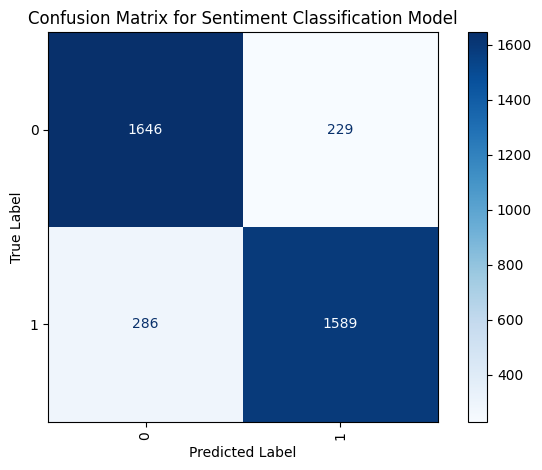

In [67]:
display_confusion_matrix(y_valid, y_preds, labels=sentiment_classifier.classes_)

## Saving Model Pipeline

The model pipeline will be saved in the model’s directory by using the joblib python package.

In [68]:
#save model 
import joblib 
joblib.dump(sentiment_classifier, 'model/sentiment_model_pipeline.pkl')

['model/sentiment_model_pipeline.pkl']